The nuts and bolts of Deep Graph Learning, with loading graph data and training a Vanilla GCN in PyTorch.

In [ ]:
import torch
torch.__version__

'1.6.0+cu101'

In [ ]:
! wget -q https://github.com/tkipf/pygcn/raw/master/data/cora/cora.cites
! wget -q https://github.com/tkipf/pygcn/raw/master/data/cora/cora.content

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch

In [ ]:
def encode_onehot(labels):
  classes      = set(labels)
  classes_dict = {c : np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
  labels_oh    = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
  return labels_oh

## The Dataset (Cora)

The Cora dataset consists of ML papers, classified into one of the following seven classes:
-	Case_Based
-	Genetic_Algorithms
-	Neural_Networks
-	Probabilistic_Methods
-	Reinforcement_Learning
-	Rule_Learning
-	Theory

The papers were selected in a way such that in the final corpus every paper cites or is cited by atleast one other paper. There are 2708 papers in the whole corpus. 

After stemming and removing stopwords we were left with a vocabulary of size 1433 unique words. 

`cora.content` contains descriptions of the papers in the following format:

		<paper_id> <word_attributes> <class_label>

The first entry in each line contains the unique string ID of the paper followed by binary values indicating whether each word in the vocabulary is present (indicated by 1) or absent (indicated by 0) in the paper. Finally, the last entry in the line contains the class label of the paper.

`cora.cites` contains the citation graph of the corpus. Each line describes a link in the following format:

		<ID of cited paper> <ID of citing paper>

Each line contains two paper IDs. The first entry is the ID of the paper being cited and the second ID stands for the paper which contains the citation. The direction of the link is from right to left. If a line is represented by "paper1 paper2" then the link is "paper2->paper1". 

In [ ]:
def load_data(path='./', dataset='cora'):
  idx_features_labels = np.genfromtxt(f'{path}{dataset}.content', dtype=np.dtype(str))
  features            = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
  labels              = encode_onehot(idx_features_labels[:, -1])                       # the target
  idx                 = np.array(idx_features_labels[:, 0], dtype=np.int32)
  idx_map             = {j : i for i, j in enumerate(idx)}                              # build graph
  edges_unordered     = np.genfromtxt(f'{path}{dataset}.cites', dtype=np.int32)
  edges               = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32)
  edges               = edges.reshape(edges_unordered.shape)
  edges_t             = (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1]))
  adj                 = sp.coo_matrix(edges_t, shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)
  adj                 = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)   # symmetric 
  features            = normalize(features)
  adj                 = normalize(adj + sp.eye(adj.shape[0]))
  idx_train           = range(140)
  idx_val             = range(200, 500)
  idx_test            = range(500, 1500)
  features            = torch.FloatTensor(np.array(features.todense()))
  labels              = torch.LongTensor(np.where(labels)[1])
  adj                 = sparse_mx_to_torch_sparse_tensor(adj)
  idx_train           = torch.LongTensor(idx_train)
  idx_val             = torch.LongTensor(idx_val)
  idx_test            = torch.LongTensor(idx_test)
  return adj, features, labels, idx_train, idx_val, idx_test

In [ ]:
def normalize(mx):
  rowsum = np.array(mx.sum(1))
  r_inv  = np.power(rowsum, -1).flatten()
  r_inv[np.isinf(r_inv)] = 0.
  r_mat_inv = sp.diags(r_inv)
  mx = r_mat_inv.dot(mx)
  return mx

def accuracy(output, labels):
  preds   = output.max(1)[1].type_as(labels)
  correct = preds.eq(labels).double()
  correct = correct.sum()
  return correct / len(labels)

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [ ]:
adj, features, labels, idx_train, idx_val, idx_test = load_data()

In [ ]:
features.shape

torch.Size([2708, 1433])

In [ ]:
adj.shape

torch.Size([2708, 2708])

In [ ]:
min([sum(features[z]) for z in range(2708)])

tensor(1.0000)

In [ ]:
idx_train

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [ ]:
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class GraphConv(nn.Module):

  def __init__(self, in_features, out_features, bias=True):
    super(GraphConv, self).__init__()
    self.in_features  = in_features
    self.out_features = out_features
    self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
    if bias:
      self.bias = nn.Parameter(torch.Tensor(out_features))
    else:
      self.register_parameter('bias', None)
    self.reset_parameters()
    
  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    if self.bias is not None:
      self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input, adj):
    support = torch.mm(input, self.weight)
    output = torch.spmm(adj, support)
    if self.bias is not None:
        return output + self.bias
    else:
        return output

    def __repr__(self):
      return self.__class__.__name__ +' ('+str(self.in_features)+' -> '+str(self.out_features)+')'

In [ ]:
class VanillaGCN(nn.Module):

  def __init__(self, nfeat, nhid, nclass, dropout):
    super(VanillaGCN, self).__init__()
    self.gc1 = GraphConv(nfeat, nhid)
    self.gc2 = GraphConv(nhid, nclass)
    self.dropout = dropout

  def forward(self, x, adj):
    x = F.relu(self.gc1(x, adj))
    x = F.dropout(x, self.dropout, training=self.training)
    x = self.gc2(x, adj)
    return F.log_softmax(x, dim=1)

In [ ]:
CUDA = torch.cuda.is_available()
SEED = 42
torch.manual_seed(SEED)
if CUDA: torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
lr = 0.01
epochs = 200
wd = 5e-4
hidden = 16
dropout = 0.5
fastmode = False

In [ ]:
model = VanillaGCN(nfeat=features.shape[1], nhid=hidden, nclass=labels.max().item() + 1, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
if CUDA:
  model.cuda()
  features = features.cuda()
  adj = adj.cuda()
  labels = labels.cuda()
  idx_train = idx_train.cuda()
  idx_val = idx_val.cuda()
  idx_test = idx_test.cuda()

In [ ]:
def train(epoch):
  t = time.time()
  model.train()
  optimizer.zero_grad()
  output = model(features, adj)
  loss_train = F.nll_loss(output[idx_train], labels[idx_train])
  acc_train = accuracy(output[idx_train], labels[idx_train])
  loss_train.backward()
  optimizer.step()
  if not fastmode:
      model.eval()
      output = model(features, adj)
  loss_val = F.nll_loss(output[idx_val], labels[idx_val])
  acc_val = accuracy(output[idx_val], labels[idx_val])
  print('Epoch: {:04d}'.format(epoch+1),
        'loss_train: {:.4f}'.format(loss_train.item()),
        'acc_train: {:.4f}'.format(acc_train.item()),
        'loss_val: {:.4f}'.format(loss_val.item()),
        'acc_val: {:.4f}'.format(acc_val.item()),
        'time: {:.4f}s'.format(time.time() - t))
  return loss_train.item(), loss_val.item()

In [ ]:
def test():
  model.eval()
  output = model(features, adj)
  loss_test = F.nll_loss(output[idx_test], labels[idx_test])
  acc_test = accuracy(output[idx_test], labels[idx_test])
  print("Test set results:",
        "loss= {:.4f}".format(loss_test.item()),
        "accuracy= {:.4f}".format(acc_test.item()))

In [ ]:
import time
t_total = time.time()
train_losses, val_losses = [], []
for epoch in range(epochs):
  loss_train, loss_val = train(epoch)
  train_losses.append(loss_train)
  val_losses.append(loss_val)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0001 loss_train: 1.9756 acc_train: 0.1071 loss_val: 1.9451 acc_val: 0.1033 time: 0.0269s
Epoch: 0002 loss_train: 1.9480 acc_train: 0.1071 loss_val: 1.9284 acc_val: 0.1033 time: 0.0199s
Epoch: 0003 loss_train: 1.9359 acc_train: 0.1214 loss_val: 1.9128 acc_val: 0.1067 time: 0.0175s
Epoch: 0004 loss_train: 1.9229 acc_train: 0.2000 loss_val: 1.8981 acc_val: 0.3767 time: 0.0166s
Epoch: 0005 loss_train: 1.9007 acc_train: 0.2714 loss_val: 1.8841 acc_val: 0.3500 time: 0.0170s
Epoch: 0006 loss_train: 1.8943 acc_train: 0.2929 loss_val: 1.8706 acc_val: 0.3500 time: 0.0194s
Epoch: 0007 loss_train: 1.8763 acc_train: 0.2929 loss_val: 1.8575 acc_val: 0.3500 time: 0.0169s
Epoch: 0008 loss_train: 1.8596 acc_train: 0.2929 loss_val: 1.8445 acc_val: 0.3500 time: 0.0170s
Epoch: 0009 loss_train: 1.8480 acc_train: 0.2929 loss_val: 1.8318 acc_val: 0.3500 time: 0.0177s
Epoch: 0010 loss_train: 1.8312 acc_train: 0.2929 loss_val: 1.8196 acc_val: 0.3500 time: 0.0154s
Epoch: 0011 loss_train: 1.8224 acc_train

In [ ]:
test()

Test set results: loss= 0.7075 accuracy= 0.8350


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

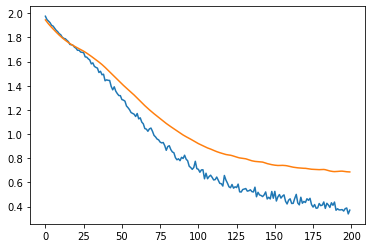

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')

Sometime soon, we'll have week-13 of [this](https://www.youtube.com/watch?v=f01J0Dri-6k&list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq&index=24&t=0s) and that should be really good!

Also, ICML 2020 had a workshop on [GRL+](https://slideslive.com/icml-2020/graph-representation-learning-and-beyond-grl), should definitely watch relevant presentations